In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from pathlib import Path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import shutil
import librosa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt
import random as rn
from sklearn.metrics import f1_score 

from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
recordings_path = os.getcwd() + '\\recordings'

file_names = os.listdir(recordings_path)

all_files = [(recordings_path + '\\' + i) for i in file_names]
labels = [i[0][0] for i in file_names]

In [3]:
np.unique(labels)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

<font size=4>Grader function 1 </font>

In [4]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [5]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0
file_dict = {'path':all_files,'label':labels}

df_audio = pd.DataFrame(file_dict)

df_audio = shuffle(df_audio, random_state=33)

In [6]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 766 to 1044
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB


<font size=4>Grader function 2 </font>

In [7]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [8]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [9]:
X = df_audio['path']
y = df_audio['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=45, stratify=y)

<font size=4>Grader function 3 </font>

In [10]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

In [11]:
y_train = np.array([int(i) for i in y_train])
y_test = np.array([int(i) for i in y_test])

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [12]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [13]:
train_wav = X_train.apply(lambda x: load_wav(x))
samples = [i[0] for i in train_wav]
duration = [i[1] for i in train_wav]
train_index = list(X_train.index)
train_dict = {'raw_data':samples, 'duration':duration}
X_train_processed = pd.DataFrame(train_dict, index=train_index)

In [14]:
test_wav = X_test.apply(lambda x: load_wav(x))
samples = [i[0] for i in test_wav]
duration = [i[1] for i in test_wav]
test_index = list(X_test.index)
test_dict = {'raw_data':samples, 'duration':duration}
X_test_processed = pd.DataFrame(test_dict, index=test_index)

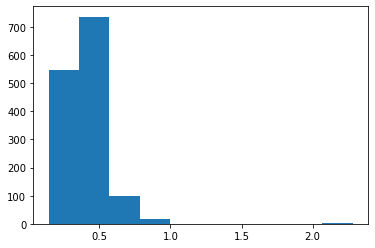

In [15]:
plt.hist(X_train_processed['duration'])
plt.show()

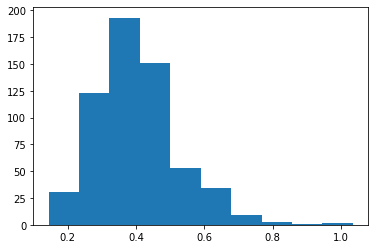

In [16]:
plt.hist(X_test_processed['duration'])
plt.show()

In [17]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0,101, 10):
    print(i,'th percentile is', np.percentile(X_train_processed['duration'], i))

0 th percentile is 0.1435374149659864
10 th percentile is 0.2582630385487528
20 th percentile is 0.2996371882086168
30 th percentile is 0.33207256235827665
40 th percentile is 0.3596371882086168
50 th percentile is 0.39045351473922907
60 th percentile is 0.4171156462585034
70 th percentile is 0.4465850340136054
80 th percentile is 0.4846530612244898
90 th percentile is 0.5528934240362812
100 th percentile is 2.282766439909297


In [18]:
##print 90 to 100 percentile values with step size of 1. 
for i in range(90,101, 1):
    print(i,'th percentile is', np.percentile(X_train_processed['duration'], i))

90 th percentile is 0.5528934240362812
91 th percentile is 0.5619047619047619
92 th percentile is 0.5760671201814062
93 th percentile is 0.5941251700680278
94 th percentile is 0.6120943310657596
95 th percentile is 0.6330226757369615
96 th percentile is 0.6447981859410431
97 th percentile is 0.6647700680272108
98 th percentile is 0.6956090702947844
99 th percentile is 0.8072766439909297
100 th percentile is 2.282766439909297


<font size=4>Grader function 4 </font>

In [19]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [20]:
max_length  = 17640

In [21]:
X_train_pad_seq = []
X_train_mask = []
for i in train_index:
    length = len(X_train_processed.loc[i, 'raw_data'])
    value = X_train_processed.loc[i, 'raw_data']
    if (length >= max_length):
        X_train_pad_seq.append(value[0:max_length])
        X_train_mask.append(np.ones(max_length))
    else:
        zero_pad = np.zeros(max_length - length)
        mask_one_padd = np.ones(length - 1)
        mask_zero_padd = np.zeros((max_length - length) + 1)
        X_train_pad_seq.append(np.concatenate((value, zero_pad)))
        X_train_mask.append(np.concatenate((mask_one_padd, mask_zero_padd)))
        
X_train_pad_seq = np.array(X_train_pad_seq)
X_train_mask = np.array(X_train_mask)
X_train_mask = X_train_mask.astype('bool')

print(X_train_pad_seq.shape)
print(X_train_mask.shape)

(1400, 17640)
(1400, 17640)


In [22]:
print(X_train_pad_seq[0:5])
print('\n')
print(X_train_mask[0:5])

[[-6.46304616e-05 -1.03010592e-04 -1.59132222e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.36712292e-03 -9.12982132e-03 -9.19409655e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.02168259e-04  2.75946519e-07  2.25390177e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.44477371e-04 -1.69934088e-03 -4.19601100e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.29699093e-03 -1.09779211e-02 -1.10168587e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


In [23]:
X_test_pad_seq = []
X_test_mask = []
for i in test_index:
    length = len(X_test_processed.loc[i, 'raw_data'])
    value = X_test_processed.loc[i, 'raw_data']
    if (length > max_length):
        X_test_pad_seq.append(value[0:max_length])
        X_test_mask.append(np.ones(max_length))
    else:
        zero_pad = np.zeros(max_length - length)
        mask_one_padd = np.ones(length - 1)
        mask_zero_padd = np.zeros((max_length - length) + 1)
        X_test_pad_seq.append(np.concatenate((value, zero_pad)))
        X_test_mask.append(np.concatenate((mask_one_padd, mask_zero_padd)))
        
X_test_pad_seq = np.array(X_test_pad_seq)
X_test_mask = np.array(X_test_mask)
X_test_mask = X_test_mask.astype('bool')

print(X_test_pad_seq.shape)
print(X_test_mask.shape)

(600, 17640)
(600, 17640)


In [24]:
print(X_test_pad_seq[0:5])
print('\n')
print(X_test_mask[0:5])

[[ 5.69634663e-04  6.73947972e-04  4.90176899e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.60761619e-04  7.77264213e-05 -1.72803571e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.98726615e-02  3.13351192e-02  2.78438795e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.59053840e-04 -9.80457116e-05  3.04512709e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.44157597e-03  1.12675084e-02  1.14977006e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


<font size=4>Grader function 5 </font>

In [25]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### 1. Giving Raw data directly. 

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). 
3. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
4. make sure that it won't overfit. 
5. You are free to include any regularization
</pre>

In [26]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

In [27]:
input_ = tf.keras.Input(shape=(17640, 1), name='Input_Layer')
mask_input = tf.keras.Input(shape=(17640), name='Mask_Input_Layer')
lstm = LSTM(25, kernel_initializer='he_normal', name='LSTM_Layer')(input_)
dense = tf.keras.layers.Dense(50, name='Dense_Layer')(lstm)
output = tf.keras.layers.Dense(10, activation='softmax', name='Output')(dense)
model = Model(inputs=[input_, mask_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
LSTM_Layer (LSTM)               (None, 25)           2700        Input_Layer[0][0]                
__________________________________________________________________________________________________
Dense_Layer (Dense)             (None, 50)           1300        LSTM_Layer[0][0]                 
__________________________________________________________________________________________________
Mask_Input_Layer (InputLayer)   [(None, 17640)]      0                                            
______________________________________________________________________________________________

In [28]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, train_data, validation, target):   
        super(F1Metrics, self).__init__()
        self.train_data = train_data
        self.validation_data = validation
        self.target = target

    def on_epoch_end(self, epoch, logs={}):
        predict = self.model.predict(self.train_data[0])
        predict = np.argmax(predict, axis=1)
        
        val_predict = self.model.predict(self.validation_data[0])
        val_predict = np.argmax(val_predict, axis=1)

        target = self.train_data[1]
        val_target = self.validation_data[1]
        
        f1 = f1_score(target, predict, average='micro')
        val_f1 = f1_score(val_target, val_predict, average='micro')

        print(', f1:', f1, ', val_f1:', val_f1)

        if (val_f1 > self.target):
            self.model.stop_training = True
            print('\033[1m' + '\n Validation F1 score reached the target...!\n' + '\033[0m') 
        return
    
f1 = F1Metrics((X_train_pad_seq, y_train), (X_test_pad_seq, y_test), 0.1)

In [29]:
# Reference: Assignment
log_path = os.getcwd() + '\\logs'
if(path.exists(log_path)):
    shutil.rmtree(log_path)
    print('Old Log folder is deleted')

%reload_ext tensorboard

log_dir = log_path
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)
print('New Log folder is created')

Old Log folder is deleted
New Log folder is created


In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', 
              metrics=['acc'])

In [31]:
#train your model
model.fit([X_train_pad_seq, X_train_mask], y_train, epochs=5, batch_size=64, 
          validation_data=([X_test_pad_seq, X_test_mask], y_test),
          callbacks = [f1, tensorboard_callback])

Epoch 1/5
22/22 [==============================] - ETA: 0s - loss: 2.3036 - acc: 0.0900, f1: 0.10000000000000002 , val_f1: 0.10166666666666667

 Validation F1 score reached the target...!

22/22 [==============================] - 20s 931ms/step - loss: 2.3036 - acc: 0.0900 - val_loss: 2.3026 - val_acc: 0.1017


In [34]:
# %tensorboard --logdir logs

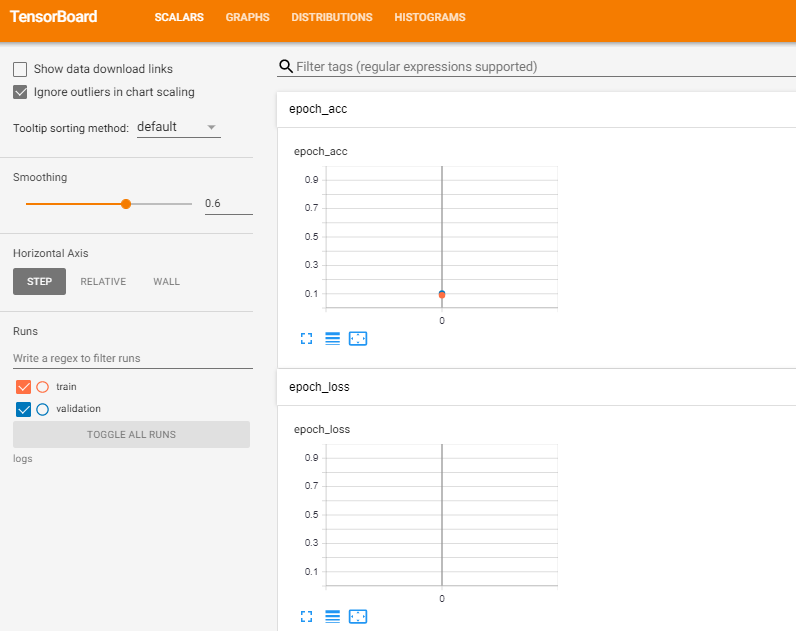

In [35]:
from IPython.display import Image
Image(filename='F:\\Applied AI\\Assignments\\28.Spoken Digit Recognition\\Tensorboard Results\\Task_1.PNG')